--- Stage 1: LinearRegression ---
MAE: 256456 tons
R2: 0.3224
Learned conversion rate: 0.1426

--- Stage 1: RandomForest ---
MAE: 291447 tons
R2: 0.2072

--- Stage 1: SVR ---
MAE: 345748 tons
R2: -0.0233

--- Stage 1: XGBoost ---
MAE: 333000 tons
R2: -0.1554



c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
--- Stage 1: LSTM ---
MAE: 303849 tons
R2: -0.1126

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
--- Stage 1: GRU ---
MAE: 286718 tons
R2: 0.0490

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Best Stage 1 model: LinearRegression
--- Stage 2: Exported Sugar Prediction (Linear Regression) ---
MAE: 71300 tons
R2: 0.9164



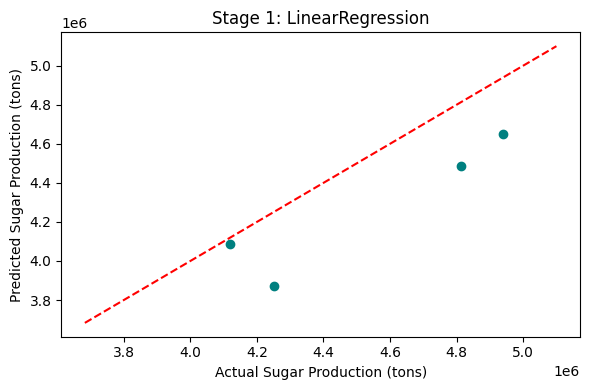

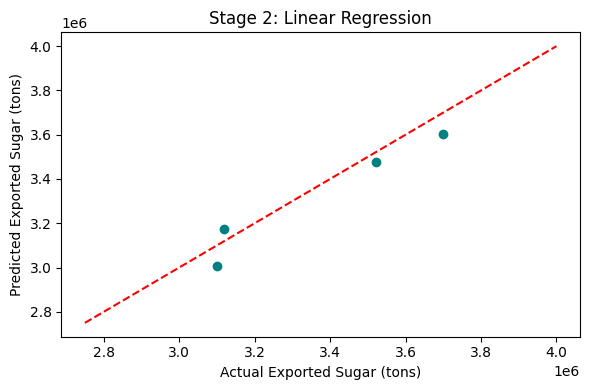

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_excel('Australia.xlsx')
df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
for col in ['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)

# Stage 1: Predict Sugar Production
df['land_yield'] = df['Land_used(ha)'] * df['Sugarcane_Yield(t/ha)']
X1 = df[['land_yield']]
y1 = df['Sugar_Prod(tons)']

# Split data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Scale for non-linear models
scaler_X1 = MinMaxScaler()
X1_train_scaled = scaler_X1.fit_transform(X1_train)
X1_test_scaled = scaler_X1.transform(X1_test)

# Define models for Stage 1
models_stage1 = {
    'LinearRegression': LinearRegression(fit_intercept=False),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

stage1_results = {}
stage1_preds_full = {}

# Train and evaluate models
for name, model in models_stage1.items():
    if name == 'LinearRegression':
        model.fit(X1_train, y1_train)
        y1_pred = model.predict(X1_test)
        preds_full = model.predict(X1)
    else:
        model.fit(X1_train_scaled, y1_train)
        y1_pred = model.predict(X1_test_scaled)
        preds_full = model.predict(scaler_X1.transform(X1))
    mae = mean_absolute_error(y1_test, y1_pred)
    r2 = r2_score(y1_test, y1_pred)
    print(f"--- Stage 1: {name} ---")
    print(f"MAE: {mae:.0f} tons")
    print(f"R2: {r2:.4f}")
    if name == 'LinearRegression':
        print(f"Learned conversion rate: {model.coef_[0]:.4f}")
    print()
    stage1_results[name] = {'MAE': mae, 'R2': r2}
    stage1_preds_full[name] = preds_full

# LSTM and GRU setup
scaler_y = MinMaxScaler()
y1_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1))
X1_seq = scaler_X1.fit_transform(X1).reshape((X1.shape[0], 1, 1))
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X1_seq, y1_scaled, test_size=0.2, random_state=42)

# LSTM
def build_lstm():
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm()
lstm_model.fit(X_seq_train, y_seq_train, epochs=100, verbose=0, batch_size=4, callbacks=[EarlyStopping(patience=10)], validation_split=0.2)
y_pred_lstm_scaled = lstm_model.predict(X_seq_test)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
mae_lstm = mean_absolute_error(y1_test, y_pred_lstm)
r2_lstm = r2_score(y1_test, y_pred_lstm)
print("--- Stage 1: LSTM ---")
print(f"MAE: {mae_lstm:.0f} tons")
print(f"R2: {r2_lstm:.4f}")
print()
stage1_results['LSTM'] = {'MAE': mae_lstm, 'R2': r2_lstm}
stage1_preds_full['LSTM'] = scaler_y.inverse_transform(lstm_model.predict(X1_seq)).flatten()

# GRU
def build_gru():
    model = Sequential()
    model.add(GRU(10, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

gru_model = build_gru()
gru_model.fit(X_seq_train, y_seq_train, epochs=100, verbose=0, batch_size=4, callbacks=[EarlyStopping(patience=10)], validation_split=0.2)
y_pred_gru_scaled = gru_model.predict(X_seq_test)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled)
mae_gru = mean_absolute_error(y1_test, y_pred_gru)
r2_gru = r2_score(y1_test, y_pred_gru)
print("--- Stage 1: GRU ---")
print(f"MAE: {mae_gru:.0f} tons")
print(f"R2: {r2_gru:.4f}")
print()
stage1_results['GRU'] = {'MAE': mae_gru, 'R2': r2_gru}
stage1_preds_full['GRU'] = scaler_y.inverse_transform(gru_model.predict(X1_seq)).flatten()

# Select best Stage 1 model (lowest MAE)
best_model_name = min(stage1_results, key=lambda k: stage1_results[k]['MAE'])
print(f"Best Stage 1 model: {best_model_name}")
df['Predicted_Sugar_Prod'] = stage1_preds_full[best_model_name]

# Stage 2: Predict Exported Sugar
X2 = df[['Predicted_Sugar_Prod']]
y2 = df['Exported_sugar(tons)']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model_stage2 = LinearRegression()
model_stage2.fit(X2_train, y2_train)
y2_pred = model_stage2.predict(X2_test)
print("--- Stage 2: Exported Sugar Prediction (Linear Regression) ---")
print(f"MAE: {mean_absolute_error(y2_test, y2_pred):.0f} tons")
print(f"R2: {r2_score(y2_test, y2_pred):.4f}")
print()

# Visualization
plt.figure(figsize=(6, 4))
plt.scatter(y1_test, models_stage1[best_model_name].predict(X1_test) if best_model_name == 'LinearRegression' else models_stage1[best_model_name].predict(X1_test_scaled), color='teal')
plt.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'r--')
plt.xlabel("Actual Sugar Production (tons)")
plt.ylabel("Predicted Sugar Production (tons)")
plt.title(f"Stage 1: {best_model_name}")
plt.tight_layout()
plt.savefig('stage1_plot.png')

plt.figure(figsize=(6, 4))
plt.scatter(y2_test, y2_pred, color='teal')
plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'r--')
plt.xlabel("Actual Exported Sugar (tons)")
plt.ylabel("Predicted Exported Sugar (tons)")
plt.title("Stage 2: Linear Regression")
plt.tight_layout()
plt.savefig('stage2_plot.png')


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# Load and clean data
df = pd.read_excel('Australia.xlsx')
df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
for col in ['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)

# Create interaction term
df['land_yield'] = df['Land_used(ha)'] * df['Sugarcane_Yield(t/ha)']
X1 = df[['land_yield']]
y1 = df['Sugar_Prod(tons)']

# Scale features
scaler_X1 = MinMaxScaler()
X1_scaled = scaler_X1.fit_transform(X1)

# Split data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }),
    'XGBoost': (xgb.XGBRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    })
}

# Stage 1: Sugar Production Prediction
print("--- Stage 1: Sugar Production Prediction ---")
best_model_stage1 = None
best_r2_stage1 = -float('inf')

for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(X1_train, y1_train)
    best_model = grid_search.best_estimator_
    y1_pred = best_model.predict(X1_test)
    mae = mean_absolute_error(y1_test, y1_pred)
    r2 = r2_score(y1_test, y1_pred)
    print(f"{name}: MAE = {mae:.0f} tons, R2 = {r2:.4f}")
    if r2 > best_r2_stage1:
        best_r2_stage1 = r2
        best_model_stage1 = best_model

# Predict for entire dataset using the best model
df['Predicted_Sugar_Prod'] = best_model_stage1.predict(X1_scaled)
print()

# Stage 2: Exported Sugar Prediction
X2 = df[['Predicted_Sugar_Prod']]
y2 = df['Exported_sugar(tons)']

# Scale features
scaler_X2 = MinMaxScaler()
X2_scaled = scaler_X2.fit_transform(X2)

# Split data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.2, random_state=42)

# Stage 2: Evaluate models
print("--- Stage 2: Exported Sugar Prediction ---")
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(X2_train, y2_train)
    best_model = grid_search.best_estimator_
    y2_pred = best_model.predict(X2_test)
    mae = mean_absolute_error(y2_test, y2_pred)
    r2 = r2_score(y2_test, y2_pred)
    print(f"{name}: MAE = {mae:.0f} tons, R2 = {r2:.4f}")
print()

--- Stage 1: Sugar Production Prediction ---
Random Forest: MAE = 291991 tons, R2 = 0.2080
Gradient Boosting: MAE = 266759 tons, R2 = 0.1789
XGBoost: MAE = 331270 tons, R2 = -0.1341

--- Stage 2: Exported Sugar Prediction ---
Random Forest: MAE = 180877 tons, R2 = 0.2615
Gradient Boosting: MAE = 218042 tons, R2 = -0.2072
XGBoost: MAE = 204709 tons, R2 = -0.1097

